In [1]:
import numpy as np
from scipy.optimize import curve_fit
from utils import sample_observed_data_berkson, sample_observed_data_classical

In [2]:
confidence_level = 0.90
num_realizations = 100
seed = 12
folder_path = '/dcs/pg23/u1604520/mem/results/exponential_classical_unifstart/'
folder_path_simex = folder_path+'simex/exponential_classical_unifstart/'

In [3]:
scales_nu = [0.000001, 0.5,  1.0, 2.0] #, 2.0]
num_scales = len(scales_nu)
c = 100
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3

In [4]:
def reg_func(theta,x):
    return (np.exp(theta[0] + theta[1]*x))/(1 + np.exp(theta[0] + theta[1]*x))

In [5]:
def nonlinear_model(x, a, b):
    return (np.exp(a + b*x))/(1 + np.exp(a + b*x)) #a + b*x + c*x**2

In [24]:
mses = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
for j, scale_nu in enumerate(scales_nu):
    seed = 12
    counts = np.zeros((len(theta_star)))
    for r in range(num_realizations):
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, x = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        #mean_simex_sample = simex_sample.mean(axis=0)
        initial_guess = [0,0] #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        mses[j, r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
        mses[j, r, 1, :] = np.asarray((simex_sample - theta_star)**2)
        mses[j, r, 2, :] = np.asarray((ls_estimator - theta_star)**2)

        # Credible interval 
        for i in range(len(theta_star)):
            count = 0
            lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
            upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
            if lower_bound <= theta_star[i] <= upper_bound:
                count += 1
            counts[i] += count
            
    # Calculate the coverage probability
    coverage_probabilities = counts / num_realizations
    mses_over_runs = np.mean(mses, axis=0)
    stds_mses_over_runs = np.std(mses, axis=0)
        
    print(f"Coverage Probability for theta_1 for ME std {scale_nu}: {coverage_probabilities[0] * 100}%")
    print(f"Coverage Probability for theta_2 for ME std {scale_nu}: {coverage_probabilities[1] * 100}%")
    #print(f"Coverage Probability for theta_3 for ME std {scale_nu}: {coverage_probabilities[2] * 100}%")
    print(f"Mean Squared error for Robust-MEM: {mses_over_runs[j, 0, :]}")
    print(f"Mean Squared error for SIMEX: {mses_over_runs[j, 1, :]}")
    print(f"Mean Squared error for Least Squares: {mses_over_runs[j, 2, :]}")
    print(f"Std - Mean Squared error for Robust-MEM: {stds_mses_over_runs[j, 0, :]}")
    print(f"Std - Mean Squared error for SIMEX: {stds_mses_over_runs[j, 1, :]}")
    print(f"Std - Mean Squared error for Least Squares: {stds_mses_over_runs[j, 2, :]}")

Coverage Probability for theta_1 for ME std 1e-06: 97.0%
Coverage Probability for theta_2 for ME std 1e-06: 100.0%
Mean Squared error for Robust-MEM: [0.01062293 0.01486761]
Mean Squared error for SIMEX: [9.83218939e-05 3.61322551e-02]
Mean Squared error for Least Squares: [9.83206675e-05 3.61322351e-02]
Std - Mean Squared error for Robust-MEM: [0.01839946 0.02575145]
Std - Mean Squared error for SIMEX: [0.0001703 0.0625829]
Std - Mean Squared error for Least Squares: [0.0001703  0.06258287]
Coverage Probability for theta_1 for ME std 0.5: 96.0%
Coverage Probability for theta_2 for ME std 0.5: 100.0%
Mean Squared error for Robust-MEM: [0.03490373 0.00682559]
Mean Squared error for SIMEX: [0.01010819 0.06603811]
Mean Squared error for Least Squares: [0.00868422 0.14068093]
Std - Mean Squared error for Robust-MEM: [0.03494168 0.00951886]
Std - Mean Squared error for SIMEX: [0.01056849 0.06938453]
Std - Mean Squared error for Least Squares: [0.00875004 0.18942473]
Coverage Probability for

### Make a table

In [7]:
import pandas as pd

/tmp/dcs-tmp.u1604520/ipykernel_173059/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [25]:
def create_dataframe(mse_array, std_array, scale_nu, method_name):
    
    data = {'Param': ['theta_1', 'theta_2'], 'MSE': mse_array, 'Std': std_array, 'Scale_nu': scale_nu, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

In [26]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,0,:], stds_mses_over_runs[i,0,:], scale_nu, 'Robust-MEM (MMD)')
    dfs.append(df)
robustmem_df = pd.concat(dfs, ignore_index=True)

In [27]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,1,:], stds_mses_over_runs[i,1,:], scale_nu, 'SIMEX')
    dfs.append(df)
simex_df = pd.concat(dfs, ignore_index=True)

In [28]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,2,:], stds_mses_over_runs[i,2,:], scale_nu, 'LS')
    dfs.append(df)
ls_df = pd.concat(dfs, ignore_index=True)

In [29]:
df_all = pd.concat([robustmem_df, simex_df, ls_df])

In [30]:
df_all

,Param,MSE,Std,Scale_nu,Method
0,theta_1,0.026059,0.010444,0.000001,Robust-MEM (MMD)
1,theta_2,0.035783,0.017838,0.000001,Robust-MEM (MMD)
2,theta_1,0.083140,0.015211,0.500000,Robust-MEM (MMD)
3,theta_2,0.033367,0.021771,0.500000,Robust-MEM (MMD)
4,theta_1,0.036464,0.006664,1.000000,Robust-MEM (MMD)
5,theta_2,0.013279,0.004841,1.000000,Robust-MEM (MMD)
6,theta_1,0.113885,0.012706,2.000000,Robust-MEM (MMD)
7,theta_2,0.064753,0.037726,2.000000,Robust-MEM (MMD)
0,theta_1,0.001125,0.001295,0.000001,SIMEX
1,theta_2,0.265855,0.173183,0.000001,SIMEX


In [20]:
def sort_array2(x,y1,y2):
  data_test = np.zeros((len(x), 3))
  data_test[:,0] = x
  data_test[:,1] = y1
  data_test[:,2] = y2
  data_test = np.sort(data_test,axis=0)
  return data_test[:,0], data_test[:,1], data_test[:,2]

In [31]:
 def sort_array(x,y):
  data_test = np.zeros((len(x), 2))
  data_test[:,0] = x
  data_test[:,1] = y
  data_test = np.sort(data_test,axis=0)
  return data_test[:,0], data_test[:,1]

In [21]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [23]:
pip install seaborn

/dcs/pg23/u1604520/.conda/envs/mem-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


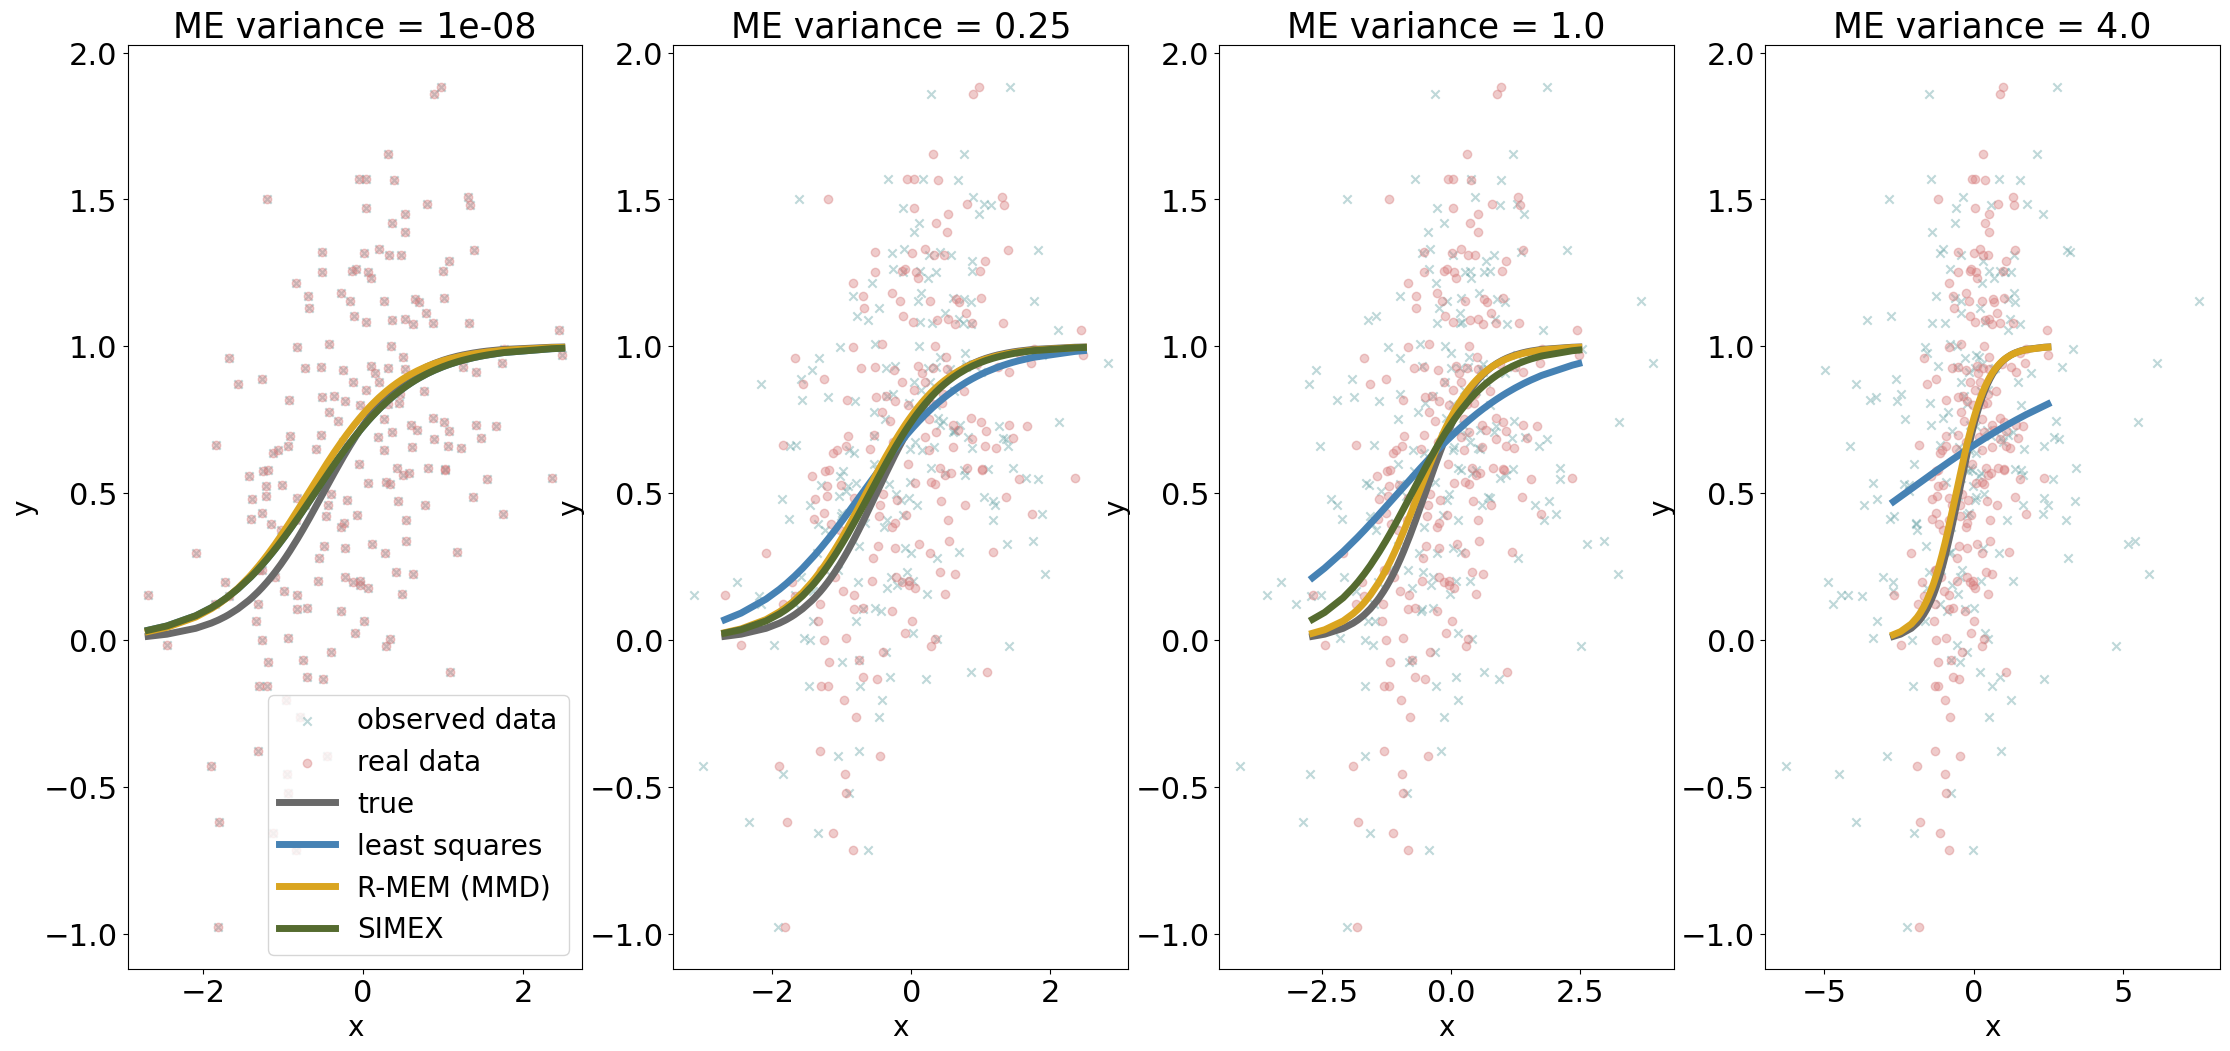

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

num_thetas = 2
scales_nu = [0.000001, 0.5,  1.0, 2.0] #, 2.0]
num_scales = len(scales_nu)
c = 100
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,12))
seed = 13

for ax, i in zip(ax_array.flatten(), range(0, num_scales)):
  scale_nu = scales_nu[i]
  boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
  thetas = np.mean(boot_sample, axis=0).flatten()
  if scale_nu == 1.0:
    simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
  elif scale_nu != 2.0 and scale_nu != 1.0:
    simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
  
  data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)
  initial_guess = [0,0] #[0, 4]  # Initial parameter guess
  ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
  
  # # Credible intervals
  # credible_interval = 0.90
  # regs = np.zeros((B,len(xis_star)))
  # for b in range(B):
  #   regs[b,:] = reg_func(thetas_all[b,:], xis_star)
  # lower_bound = np.percentile(regs, (1 - credible_interval) / 2 * 100, axis=1)
  # upper_bound = np.percentile(regs, (1 + credible_interval) / 2 * 100, axis=1)
  

  Y = reg_func(thetas, xis_star)
  Y_real = reg_func(theta_star, xis_star)
  Y_ls = reg_func(ls_estimator, xis_star)
  Y_simex = reg_func(simex_sample, xis_star)

  ax.scatter(data[:,0],data[:,1], marker="x", label='observed data', color='cadetblue', alpha=0.4)
  ax.scatter(xis_star, data[:,1], marker = "o", label='real data', color=lighten_color('indianred',amount=0.8), alpha=0.4)

  x,y = sort_array(xis_star, Y_real)
  ax.plot(x,y, label='true', color='dimgrey', lw=5)
  x,y = sort_array(xis_star, Y_ls)
  ax.plot(x,y, label='least squares', color='#4682B4', lw=5)
  x,y = sort_array(xis_star, Y)
  ax.plot(x,y, label='R-MEM (MMD)', color='goldenrod',lw=5)
  if scale_nu != 2.0:
    x,y = sort_array(xis_star, Y_simex)
    ax.plot(x,y, label='SIMEX',color='#556B2F', lw=5)
  # ax.plot(xis_star,Y, label='R-MEM (MMD)', color='goldenrod',lw=6)
  #x,y1,y2 = sort_array2(xis_star, lower_bound, upper_bound)
  #ax.fill_between(x, y1, y2, color="pink", alpha=0.3, label=f"{credible_interval * 100}% Credible Intervals")
  ax.yaxis.grid(False)
  ax.xaxis.grid(False)
  ax.patch.set_facecolor('white')
  if i == 0:
    ax.set_title(f'ME variance = 1e-08', fontsize=25)
  elif i == 1 or i == 3:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
  elif i == 2:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

  ax.set_xlabel('x',fontsize=20)
  ax.set_ylabel('y',fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=22)
  ax.tick_params(axis='both', which='minor', labelsize=22)
  if i == 0:
    ax.legend(fontsize=20)

